In [1]:
# U-Net implementation in Pytorch
# to train on the Ultralytics package-seg dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import albumentations as A

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

c:\Users\malod\anaconda3\envs\TXJP\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Load the dataset
# package_seg
# - test
#   - images
#   - labels
# - train
#   - images
#   - labels
# - valid
#   - images
#   - labels
class PackageSegDataset(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = root_dir
		self.transform = transform
		self.train_dir = os.path.join(root_dir, 'train')
		self.val_dir = os.path.join(root_dir, 'valid')
		self.test_dir = os.path.join(root_dir, 'test')
		self.train_images = os.listdir(os.path.join(self.train_dir, 'images'))
		self.val_images = os.listdir(os.path.join(self.val_dir, 'images'))
		self.test_images = os.listdir(os.path.join(self.test_dir, 'images'))
  
		# Read all images and labels
		self.images = []
		self.labels = []
		self.read_data(self.train_dir, self.train_images)
		self.read_data(self.val_dir, self.val_images)
		self.read_data(self.test_dir, self.test_images)
  
		self.preprocessed = False
  
	def read_data(self, data_dir, images):
		for img in images:
			img_path = os.path.join(data_dir, 'images', img)
			label_path = os.path.join(data_dir, 'labels', img.replace('.jpg', '.txt'))
			image = cv2.imread(img_path)
			label = []
			with open(label_path, 'r') as f:
				label_text = f.read()
				for line in label_text.split('\n'):
					if line == '':
						continue
					point_list = list(map(float, line.split(' ')[1:]))
					points = []
					for i in range(0, len(point_list), 2):
						points.append([point_list[i], point_list[i+1]])
					points = np.array(points)
					points[:, 0] *= image.shape[1]
					points[:, 1] *= image.shape[0]
	
					label.append({
				  		'label': int(line.split(' ')[0])+1,
						'points': points
					})
			self.images.append(image)
			self.labels.append(label)
   
	def preprocess(self):
		self.masks = []
		self.bboxes = []
		for i in range(len(self.images)):
			image = self.images[i]
			label = self.labels[i]
			mask = np.zeros(image.shape[:2], dtype=np.uint8)
			for l in label:
				p = l['points'].copy()
				p = p.astype(np.int32)
				cv2.fillPoly(mask, [p], l['label'])
			mask = mask[..., np.newaxis]
			self.masks.append(mask)

			bboxes = []
			for l in label:
				xmin = np.min(l['points'][:, 0])
				xmax = np.max(l['points'][:, 0])
				ymin = np.min(l['points'][:, 1])
				ymax = np.max(l['points'][:, 1])
				bboxes.append([xmin, ymin, xmax, ymax, l['label']])
			self.bboxes.append(bboxes)
		self.preprocessed = True
  
	def __len__(self):
		return len(self.train_images) + len(self.val_images) + len(self.test_images)

	def __getitem__(self, idx):
		if not self.preprocessed:
			self.preprocess()
		
		image = self.images[idx]
		mask = self.masks[idx]
		bboxes = self.bboxes[idx]
  
		if self.transform:
			augs = self.transform(image=image, mask=mask, bboxes=bboxes)
			tfImage = augs['image']
			tfMask = augs['mask']
			tfBboxes = augs['bboxes']

		# Convert to PyTorch tensor
		tfImage = TF.to_tensor(tfImage)
		tfMask = torch.tensor(tfMask, dtype=torch.int8)
		tfBboxes = torch.tensor(tfBboxes, dtype=torch.float32)
  
		# Convert bboxes from [n_bboxes, 5] to [320]
		tfBboxes = tfBboxes.flatten()
		tfBboxes = torch.cat((tfBboxes, torch.zeros(320-tfBboxes.shape[0])))

		return tfImage, tfMask, tfBboxes

In [3]:
# Define the U-Net model for instance segmentation
# The model requires 2 output heads: one for segmentation masks and one for bounding boxes
class UNet(nn.Module):
	def __init__(self):
		super(UNet, self).__init__()

		# Encoder
		self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
		self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
		self.pool1 = nn.MaxPool2d(2, 2)

		self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
		self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
		self.pool2 = nn.MaxPool2d(2, 2)

		self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
		self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
		self.pool3 = nn.MaxPool2d(2, 2)

		self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
		self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
		self.pool4 = nn.MaxPool2d(2, 2)

		self.conv5_1 = nn.Conv2d(512, 1024, 3, padding=1)
		self.conv5_2 = nn.Conv2d(1024, 1024, 3, padding=1)

		# Decoder
		self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
		self.conv4_3 = nn.Conv2d(1024, 512, 3, padding=1)
		self.conv4_4 = nn.Conv2d(512, 512, 3, padding=1)

		self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
		self.conv3_3 = nn.Conv2d(512, 256, 3, padding=1)
		self.conv3_4 = nn.Conv2d(256, 256, 3, padding=1)

		self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
		self.conv2_3 = nn.Conv2d(256, 128, 3, padding=1)
		self.conv2_4 = nn.Conv2d(128, 128, 3, padding=1)
  
		self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
		self.conv1_3 = nn.Conv2d(128, 64, 3, padding=1)
		self.conv1_4 = nn.Conv2d(64, 64, 3, padding=1)

		# Segmentation head
		self.conv1_5 = nn.Conv2d(64, 1, 1)
  
		# Bounding box head with upto 64 bounding boxes
		# 64 * 5 = 320 outputs
		self.fc1 = nn.Linear(1024, 320)

	def forward(self, x):
		# Encoder
		x1 = F.relu(self.conv1_1(x))
		x1 = F.relu(self.conv1_2(x1))
		x2 = self.pool1(x1)

		x2 = F.relu(self.conv2_1(x2))
		x2 = F.relu(self.conv2_2(x2))
		x3 = self.pool2(x2)

		x3 = F.relu(self.conv3_1(x3))
		x3 = F.relu(self.conv3_2(x3))
		x4 = self.pool3(x3)

		x4 = F.relu(self.conv4_1(x4))
		x4 = F.relu(self.conv4_2(x4))
		x5 = self.pool4(x4)

		x5 = F.relu(self.conv5_1(x5))
		x5 = F.relu(self.conv5_2(x5))

		# Decoder
		x = self.upconv4(x5)
		x = torch.cat((x4, x), dim=1)
		x = F.relu(self.conv4_3(x))
		x = F.relu(self.conv4_4(x))

		x = self.upconv3(x)
		x = torch.cat((x3, x), dim=1)
		x = F.relu(self.conv3_3(x))
		x = F.relu(self.conv3_4(x))

		x = self.upconv2(x)
		x = torch.cat((x2, x), dim=1)
		x = F.relu(self.conv2_3(x))
		x = F.relu(self.conv2_4(x))

		x = self.upconv1(x)
		x = torch.cat((x1, x), dim=1)
		x = F.relu(self.conv1_3(x))
		x = F.relu(self.conv1_4(x))

		# Segmentation head
		seg = self.conv1_5(x)
		seg = F.sigmoid(seg)
  
		# Bounding box head
		x = F.adaptive_avg_pool2d(x5, (1, 1))
		x = x.view(x.size(0), -1)
		bbox = self.fc1(x)
  
		return seg, bbox

# Define the loss function
class DiceLoss(nn.Module):
	def __init__(self):
		super(DiceLoss, self).__init__()

	def forward(self, seg_pred, seg_gt):
		# Reshape to add batch dimension
		seg_pred = seg_pred.view(-1, 1)
		seg_gt = seg_gt.view(-1, 1)

		# Calculate Dice Loss
		intersection = torch.sum(seg_pred * seg_gt)
		union = torch.sum(seg_pred) + torch.sum(seg_gt)
		dice = 2 * intersection / union

		return 1 - dice

class CustomLoss(nn.Module):
	def __init__(self):
		super(CustomLoss, self).__init__()
		self.dice_loss = DiceLoss()

	def forward(self, seg_pred, seg_gt, bbox_pred, bbox_gt):
		# Reshape to add batch dimension
		seg_pred = seg_pred.view(-1, 1)	
		seg_gt = seg_gt.view(-1, 1)
  
		# Use Dice Loss for segmentation mask
		# Use Mean Squared Error for bounding box loss
		seg_loss = self.dice_loss(seg_pred, seg_gt)
		bbox_loss = F.mse_loss(bbox_pred, bbox_gt)

		return seg_loss + bbox_loss

In [4]:

# Read the dataset
transform = A.Compose([
	A.Resize(256, 256),
	A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
], bbox_params=A.BboxParams(format='pascal_voc', check_each_transform=True))

dataset = PackageSegDataset('data/package_seg', transform=transform)

dataset.preprocess()

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Number of images: {len(dataset)}")

Number of images: 2197


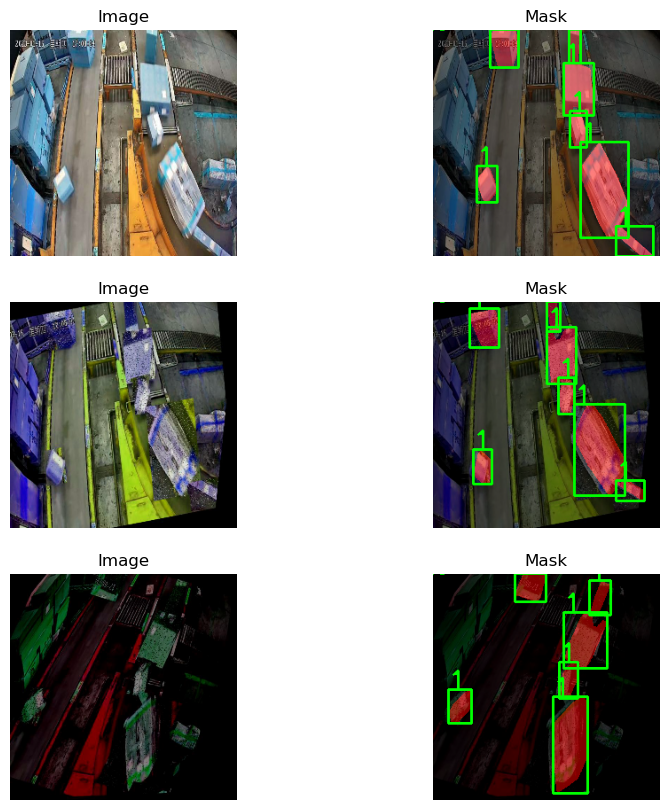

In [5]:
# Visualize the first 3 images and labels
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
for i in range(3):
	img, mask, bboxes = dataset[i]
 
	# Convert to numpy arrays
	img = img.numpy().transpose(1, 2, 0)
	mask = mask.numpy().squeeze()
	bboxes = bboxes.numpy()
 
	img = np.array(img * 255, dtype=np.uint8)
	
	# Apply different colors for each label
	unique_labels = np.unique(mask)
	color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
	color_mask[mask == 1] = np.array([255, 0, 0])

	# Overlay the mask on the image
	mask = cv2.addWeighted(img, 0.5, color_mask, 0.5, 0)
 
	# Convert bboxes from [1, 320] to [n_bboxes, 5]
	bboxes = bboxes.reshape(-1, 5)
 
	for bbox in bboxes:
		xmin, ymin, xmax, ymax, label = bbox
		label = int(label)
  
		cv2.rectangle(mask, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
		cv2.putText(mask, str(label), (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
  
	ax[i, 0].imshow(img)
	ax[i, 0].axis('off')
	ax[i, 0].set_title('Image')
 
	ax[i, 1].imshow(mask, cmap='gray')
	ax[i, 1].axis('off')
	ax[i, 1].set_title('Mask')
plt.show()

In [ ]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
	running_loss = 0.0
	for i, (images, masks, bboxes) in enumerate(dataloader):
		images = images.to(device)
		masks = masks.to(device)
		bboxes = bboxes.to(device)
  
		# Normalize the bounding boxes
		if len(bboxes.shape) == 3:
			bboxes[:, :, 0] /= 256
			bboxes[:, :, 1] /= 256
			bboxes[:, :, 2] /= 256
			bboxes[:, :, 3] /= 256

		optimizer.zero_grad()
		seg_pred, bbox_pred = model(images)
		loss = criterion(seg_pred, masks, bbox_pred, bboxes)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()
		if i % 10 == 9:
			print(f"Epoch {epoch+1}, Iteration {i+1}, Loss: {running_loss/10}")
			running_loss = 0.0
   
print("Finished Training")

Epoch 1, Iteration 10, Loss: 3540.524798583984
Epoch 1, Iteration 20, Loss: 858.2042541503906
Epoch 1, Iteration 30, Loss: 724.4261260986328
Epoch 1, Iteration 40, Loss: 441.14959716796875
Epoch 1, Iteration 50, Loss: 401.4480804443359
Epoch 1, Iteration 60, Loss: 360.9827880859375
Epoch 1, Iteration 70, Loss: 371.16285705566406
Epoch 1, Iteration 80, Loss: 369.66025695800784
Epoch 1, Iteration 90, Loss: 385.3633697509766
Epoch 1, Iteration 100, Loss: 378.0977081298828
Epoch 1, Iteration 110, Loss: 360.8498901367187
Epoch 1, Iteration 120, Loss: 400.88157348632814
Epoch 1, Iteration 130, Loss: 362.5097381591797
Epoch 2, Iteration 10, Loss: 384.2332244873047
Epoch 2, Iteration 20, Loss: 370.6527465820312
Epoch 2, Iteration 30, Loss: 396.7429626464844
Epoch 2, Iteration 40, Loss: 387.71690979003904
Epoch 2, Iteration 50, Loss: 388.9563934326172
Epoch 2, Iteration 60, Loss: 361.97483215332034
Epoch 2, Iteration 70, Loss: 416.94391479492185
Epoch 2, Iteration 80, Loss: 353.2527084350586
Ep

KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(model.state_dict(), 'unet_instance_segmentation.pth')

In [7]:
# Load the model
model = UNet()
model.load_state_dict(torch.load('unet_instance_segmentation.pth'))

C:\Users\malod\AppData\Local\Temp\ipykernel_10172\4210831671.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_instance_segmentation

<All keys matched successfully>

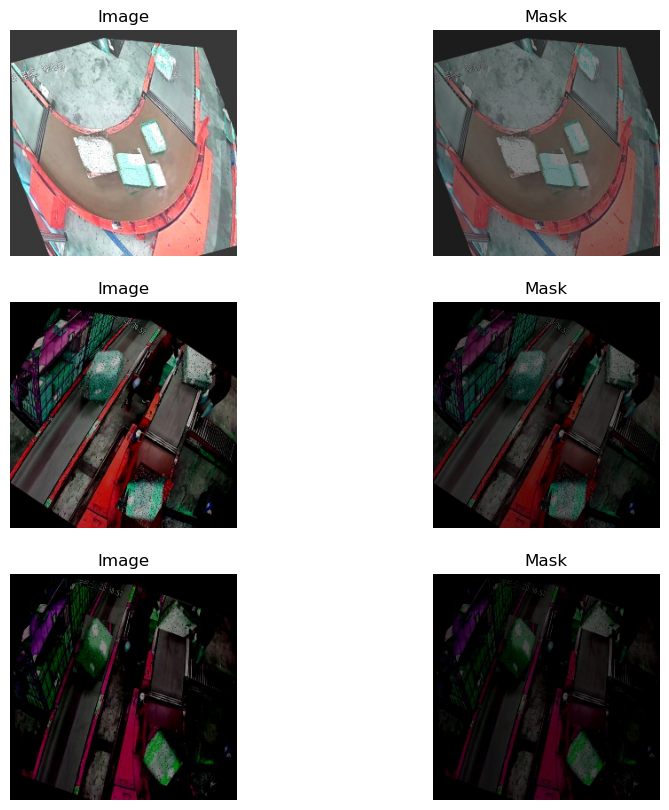

In [8]:
# Test on a few images
model.eval()

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
	img, mask, bboxes = dataset[i + 50]
 
	img.to(device)
	mask.to(device)
	bboxes.to(device)
 
	seg_pred, bbox_pred = model(img.unsqueeze(0))
 
	seg_pred = seg_pred.squeeze().detach().cpu().numpy()
	bbox_pred = bbox_pred.squeeze().detach().cpu().numpy()

	img = img.cpu().numpy().transpose(1, 2, 0)
	mask = seg_pred
	bboxes = bbox_pred
 
	img = np.array(img * 255, dtype=np.uint8)

	color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
	color_mask[mask == 1] = np.array([255, 0, 0])

	mask = cv2.addWeighted(img, 0.5, color_mask, 0.5, 0)
 
	bboxes = bboxes.reshape(-1, 5)
 
	for bbox in bboxes:
		xmin, ymin, xmax, ymax, label = bbox
		label = int(label)
  
		if label == 0:
			continue
  
		cv2.rectangle(mask, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
		cv2.putText(mask, str(label), (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
  
	ax[i, 0].imshow(img)
	ax[i, 0].axis('off')
	ax[i, 0].set_title('Image')

	ax[i, 1].imshow(mask, cmap='gray')
	ax[i, 1].axis('off')
	ax[i, 1].set_title('Mask')
 
plt.show()